In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 120 (delta 69), reused 45 (delta 18), pack-reused 0
Receiving objects: 100% (120/120), 37.28 KiB | 9.32 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 122kB 4.2MB/s 
     |████████████████████████████████| 952kB 15.6MB/s 
albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
from pytorch_utils import dataset
train, test = dataset.cifar10_albumentations()


Download finished. Extracting files.
Done.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


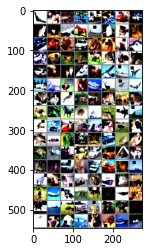

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_RESNET_S8(models.BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [13]:
import torch.optim as optim
import torch.nn as nn

from pytorch_utils import lrfinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100, step_mode="linear")


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.55E-01


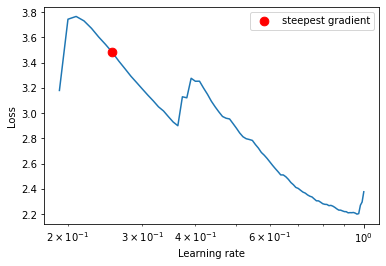

In [14]:
lr_finder.plot(skip_end=0)
# restore the model and optimizer to their initial state
lr_finder.reset()

In [15]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= 2.55E-01, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min') #StepLR(optimizer, step_size=20, gamma=0.1)
model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    scheduler.step(te_loss[0])
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5435832738876343 Batch_id=390 Accuracy=26.04: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 1964/5000 (39.28%)

EPOCH: 1


Loss=1.2694487571716309 Batch_id=390 Accuracy=44.35: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 2233/5000 (44.66%)

EPOCH: 2


Loss=1.0285913944244385 Batch_id=390 Accuracy=54.67: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 2814/5000 (56.28%)

EPOCH: 3


Loss=0.8099028468132019 Batch_id=390 Accuracy=63.62: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 3001/5000 (60.02%)

EPOCH: 4


Loss=0.8376708030700684 Batch_id=390 Accuracy=69.86: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 3450/5000 (69.00%)

EPOCH: 5


Loss=0.6230074167251587 Batch_id=390 Accuracy=72.98: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 3555/5000 (71.10%)

EPOCH: 6


Loss=0.6464973092079163 Batch_id=390 Accuracy=74.81: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 2964/5000 (59.28%)

EPOCH: 7


Loss=0.7499768733978271 Batch_id=390 Accuracy=76.47: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 3245/5000 (64.90%)

EPOCH: 8


Loss=0.7031649351119995 Batch_id=390 Accuracy=77.04: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 3760/5000 (75.20%)

EPOCH: 9


Loss=0.4505132734775543 Batch_id=390 Accuracy=77.70: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 3657/5000 (73.14%)

EPOCH: 10


Loss=0.5904039740562439 Batch_id=390 Accuracy=78.41: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 3677/5000 (73.54%)

EPOCH: 11


Loss=0.4212163984775543 Batch_id=390 Accuracy=78.57: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 3401/5000 (68.02%)

EPOCH: 12


Loss=0.5686004161834717 Batch_id=390 Accuracy=79.32: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 3248/5000 (64.96%)

EPOCH: 13


Loss=0.7096923589706421 Batch_id=390 Accuracy=79.83: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 3750/5000 (75.00%)

EPOCH: 14


Loss=0.6807456016540527 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 3857/5000 (77.14%)

EPOCH: 15


Loss=0.6549105048179626 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 3474/5000 (69.48%)

EPOCH: 16


Loss=0.48964229226112366 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 3560/5000 (71.20%)

EPOCH: 17


Loss=0.5302873849868774 Batch_id=390 Accuracy=80.71: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 3998/5000 (79.96%)

EPOCH: 18


Loss=0.6508802175521851 Batch_id=390 Accuracy=80.46: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 3964/5000 (79.28%)

EPOCH: 19


Loss=0.5483877062797546 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 3826/5000 (76.52%)

EPOCH: 20


Loss=0.43913230299949646 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 3910/5000 (78.20%)

EPOCH: 21


Loss=0.47314372658729553 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 3391/5000 (67.82%)

EPOCH: 22


Loss=0.527411699295044 Batch_id=390 Accuracy=81.19: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 3741/5000 (74.82%)

EPOCH: 23


Loss=0.5705424547195435 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 3967/5000 (79.34%)

EPOCH: 24


Loss=0.4922304153442383 Batch_id=390 Accuracy=81.43: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 3582/5000 (71.64%)

EPOCH: 25


Loss=0.47033706307411194 Batch_id=390 Accuracy=81.34: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 3884/5000 (77.68%)

EPOCH: 26


Loss=0.46937647461891174 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 3695/5000 (73.90%)

EPOCH: 27


Loss=0.446819931268692 Batch_id=390 Accuracy=81.92: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 3567/5000 (71.34%)

EPOCH: 28


Loss=0.557979941368103 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 3780/5000 (75.60%)

EPOCH: 29


Loss=0.3325088620185852 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4424/5000 (88.48%)

EPOCH: 30


Loss=0.11960145086050034 Batch_id=390 Accuracy=92.71: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 4464/5000 (89.28%)

EPOCH: 31


Loss=0.27272993326187134 Batch_id=390 Accuracy=94.08: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4437/5000 (88.74%)

EPOCH: 32


Loss=0.14183691143989563 Batch_id=390 Accuracy=95.30: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4448/5000 (88.96%)

EPOCH: 33


Loss=0.1377241313457489 Batch_id=390 Accuracy=96.05: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 4464/5000 (89.28%)

EPOCH: 34


Loss=0.13100892305374146 Batch_id=390 Accuracy=96.51: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4416/5000 (88.32%)

EPOCH: 35


Loss=0.14905615150928497 Batch_id=390 Accuracy=96.78: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4442/5000 (88.84%)

EPOCH: 36


Loss=0.058329563587903976 Batch_id=390 Accuracy=97.19: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4475/5000 (89.50%)

EPOCH: 37


Loss=0.051995158195495605 Batch_id=390 Accuracy=97.12: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4452/5000 (89.04%)

EPOCH: 38


Loss=0.10424520820379257 Batch_id=390 Accuracy=97.17: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4422/5000 (88.44%)

EPOCH: 39


Loss=0.10151763260364532 Batch_id=390 Accuracy=97.14: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4438/5000 (88.76%)

EPOCH: 40


Loss=0.20764923095703125 Batch_id=390 Accuracy=97.01: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4380/5000 (87.60%)

EPOCH: 41


Loss=0.07881834357976913 Batch_id=390 Accuracy=97.20: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4415/5000 (88.30%)

EPOCH: 42


Loss=0.05679307505488396 Batch_id=390 Accuracy=96.90: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4425/5000 (88.50%)

EPOCH: 43


Loss=0.08682750910520554 Batch_id=390 Accuracy=96.77: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4407/5000 (88.14%)

EPOCH: 44


Loss=0.06415806710720062 Batch_id=390 Accuracy=96.94: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4402/5000 (88.04%)

EPOCH: 45


Loss=0.0227835550904274 Batch_id=390 Accuracy=98.56: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 4552/5000 (91.04%)

EPOCH: 46


Loss=0.05754771828651428 Batch_id=390 Accuracy=99.30: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 4554/5000 (91.08%)

EPOCH: 47


Loss=0.012571597471833229 Batch_id=390 Accuracy=99.54: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 4583/5000 (91.66%)

EPOCH: 48


Loss=0.05662704259157181 Batch_id=390 Accuracy=99.61: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 4566/5000 (91.32%)

EPOCH: 49


Loss=0.008580191060900688 Batch_id=390 Accuracy=99.71: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Test set: Average loss: 0.0024, Accuracy: 4589/5000 (91.78%)



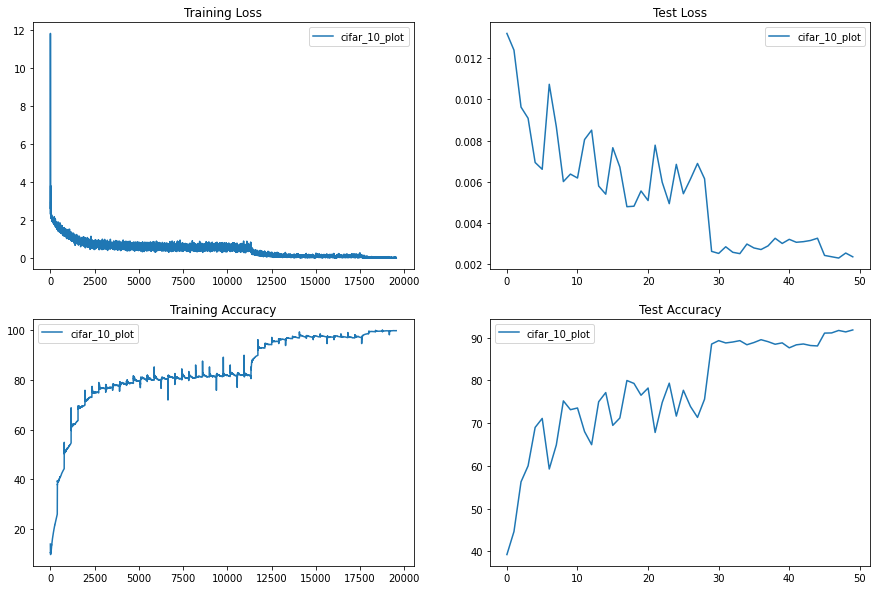

In [18]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

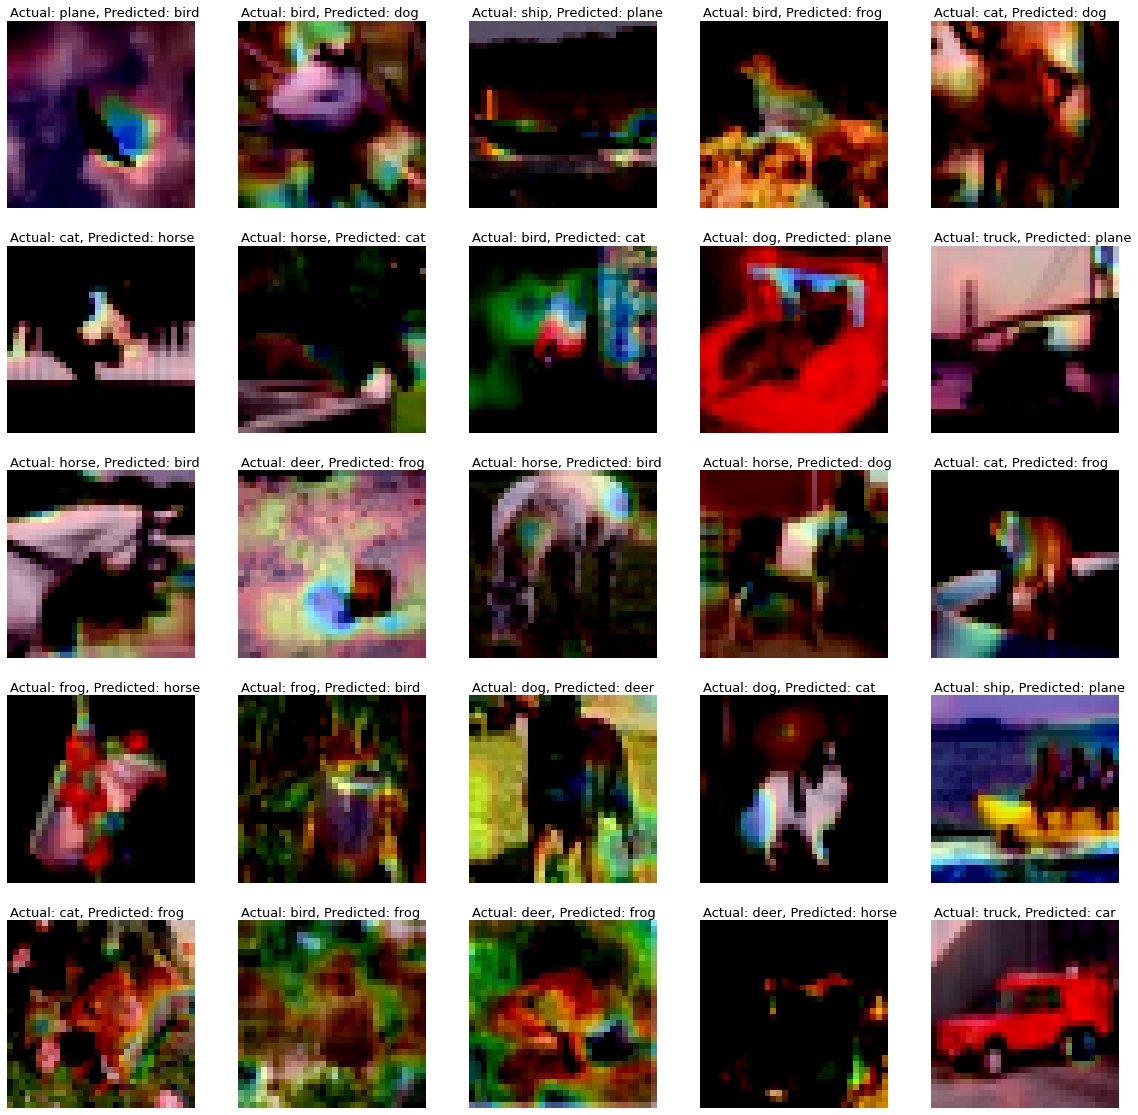

In [19]:
from pytorch_utils import gradcam

gradcam.gradcam_misclassified_images_from_model(net, testloader, classes, 25, net.layer3, ["1"])